# Round 4
## we forgor to hedge :skull:

- test different V_t functions for each option
- rolling STD and zscore

In [11]:
import numpy as np
import pandas as pd
from itertools import combinations, product
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

price_df = pd.concat([pd.read_csv("../resources/round4/prices_round_4_day_1.csv", sep=";"), pd.read_csv("../resources/round4/prices_round_4_day_2.csv", sep=";")], ignore_index=True)
obs_df = pd.concat([pd.read_csv("../resources/round4/observations_round_4_day_1.csv"), pd.read_csv("../resources/round4/observations_round_4_day_2.csv")], ignore_index=True)

def test_shifted_regressions(arrays, shift_range=range(0, 1001, 100)):
    """
    arrays: list of 5 numpy arrays (same length), 4 for X and 1 for y
    shift_range: range of shift values to test on X arrays (e.g., 0 to 500 by 50)
    
    Returns: list of results with shifts, r2 score, and model coefficients
    """
    assert len(arrays) == 4, "Expecting exactly 4 arrays"

    n = len(arrays[0])
    for arr in arrays:
        assert len(arr) == n, "All arrays must be the same length"

    results = []
    indices = [0, 1, 2, 3]

    ctr = 0
    # Try all combinations of 3 X arrays and 1 y array
    for X_idxs in combinations(indices, 3):
        y_idx = list(set(indices) - set(X_idxs))[0]
        y = arrays[y_idx]

        # Test all combinations of shifts
        for shifts in product(shift_range, repeat=3):
            max_shift = max(shifts)
            if max_shift >= n:
                continue  # Skip if shift too large for array length

            # Build shifted X matrix
            shifted_X = [
                arrays[i][max_shift - shift : n - shift]
                for i, shift in zip(X_idxs, shifts)
            ]
            X_matrix = np.column_stack(shifted_X)
            y_trimmed = y[max_shift:]

            # Fit linear model
            model = LinearRegression().fit(X_matrix, y_trimmed)
            y_pred = model.predict(X_matrix)
            r2 = r2_score(y_trimmed, y_pred)

            results.append({
                "X_indices": X_idxs,
                "y_index": y_idx,
                "shift_combination": dict(zip(X_idxs, shifts)),
                "r2_score": r2,
                "coefficients": model.coef_,
                "intercept": model.intercept_
            })
            ctr += 1
            if ctr%1000==0:
                print(ctr)

    return results

macaron_prices = price_df[price_df["product"] == "MAGNIFICENT_MACARONS"]["mid_price"]
sugar_prices = obs_df["sugarPrice"]

x1 = np.array(obs_df["sunlightIndex"])
x2 = np.array(obs_df["transportFees"])
x3 = np.array(obs_df["importTariff"])
x4 = np.array(obs_df["exportTariff"])

cur = 0
linear_prices = list()
slopes = list()
sunlight_slopes = list()

for x in range(20000):
    if x%500 == 0:
        cur = x
    l, r = sugar_prices.iloc[cur], sugar_prices.iloc[cur+499]
    slope = (r-l)/500
    slopes.append(slope)
    x_shifted = x - cur
    linear_prices.append(slope*x_shifted + l)

for x in range(20000):
    if x%1000 == 0:
        cur = x
    l, r = x1[cur], x1[cur+999]
    slope = (r-l)/1000
    sunlight_slopes.append(slope)

arrs = [sunlight_slopes, x3, x4, slopes]

results = test_shifted_regressions(arrs)

sorted_results = sorted(results, key=lambda x: x['r2_score'], reverse=True)

# Print top 5 results
for res in sorted_results[:5]:
    print(res)


20000
1000
2000
3000
4000
5000
{'X_indices': (1, 2, 3), 'y_index': 0, 'shift_combination': {1: 1000, 2: 0, 3: 0}, 'r2_score': 0.3001051911131366, 'coefficients': array([-0.00156338,  0.00832623, -0.48044525]), 'intercept': -0.08758730455099464}
{'X_indices': (1, 2, 3), 'y_index': 0, 'shift_combination': {1: 900, 2: 0, 3: 0}, 'r2_score': 0.2989876634133468, 'coefficients': array([-0.00136002,  0.0083246 , -0.48292858]), 'intercept': -0.08691667612606313}
{'X_indices': (1, 2, 3), 'y_index': 0, 'shift_combination': {1: 800, 2: 0, 3: 0}, 'r2_score': 0.2972554554686563, 'coefficients': array([-0.00094808,  0.0083674 , -0.48561296]), 'intercept': -0.0860427075685096}
{'X_indices': (0, 1, 3), 'y_index': 2, 'shift_combination': {0: 0, 1: 0, 3: 1000}, 'r2_score': 0.2960690622657073, 'coefficients': array([17.02153352, -0.37172384, -2.58091939]), 'intercept': 8.759430243950561}
{'X_indices': (1, 2, 3), 'y_index': 0, 'shift_combination': {1: 700, 2: 0, 3: 0}, 'r2_score': 0.29466550070607866, 'coe

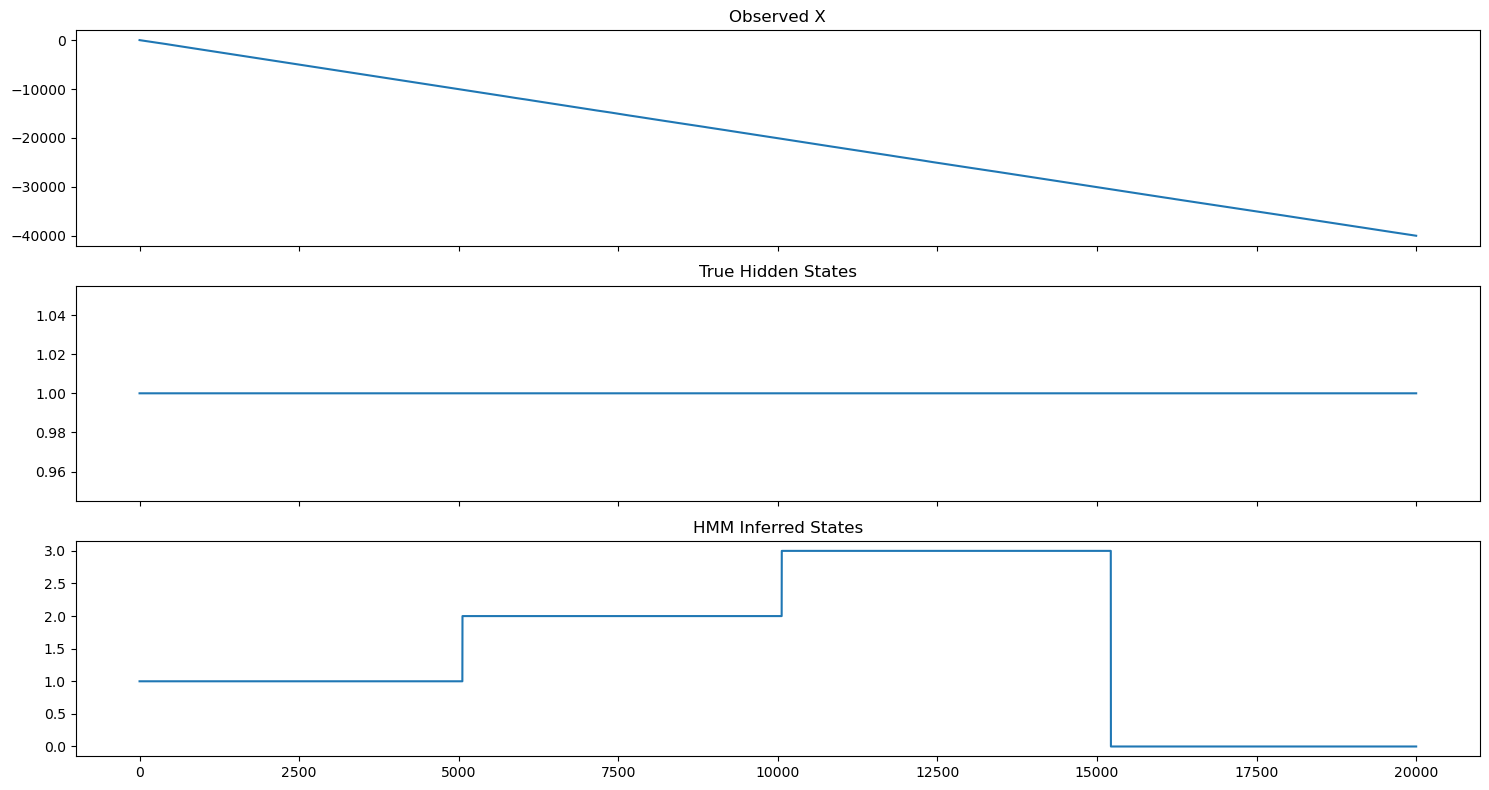

In [5]:
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

price_df = pd.concat([pd.read_csv("../resources/round4/prices_round_4_day_1.csv", sep=";"), pd.read_csv("../resources/round4/prices_round_4_day_2.csv", sep=";")], ignore_index=True)
obs_df = pd.concat([pd.read_csv("../resources/round4/observations_round_4_day_1.csv"), pd.read_csv("../resources/round4/observations_round_4_day_2.csv")], ignore_index=True)

macaron_prices = price_df[price_df["product"] == "MAGNIFICENT_MACARONS"]["mid_price"]

# Set random seed for reproducibility
np.random.seed(42)

# Hidden states
states = ["Y>Z", "Y<Z", "Y>Z_cross", "Z>Y_cross", "Y=Z"]
n_states = len(states)

# Emission: mean and std for delta X based on state
emission_params = {
    "Y>Z": (2.0, 0.5),          # Rapid increase
    "Y<Z": (-2.0, 0.5),         # Rapid decrease
    "Y>Z_cross": (1.0, 1.0),    # Variable increase
    "Z>Y_cross": (-1.0, 1.0),   # Variable decrease
    "Y=Z": (0.0, 0.1),          # Flat
}

# Transition matrix with sticky 1000-step behavior
transmat = np.full((n_states, n_states), 0.01)
np.fill_diagonal(transmat, 0.96)
transmat = transmat / transmat.sum(axis=1, keepdims=True)

# Start probabilities
start_probs = np.full(n_states, 1.0 / n_states)

# Simulate hidden state sequence
T = 20000  # total time steps
state_sequence = []
current_state = np.random.choice(n_states, p=start_probs)
for t in range(T):
    state_sequence.append(current_state)
    if t % 1000 == 999:
        current_state = np.random.choice(n_states, p=transmat[current_state])

state_sequence = np.array(state_sequence)

# Generate X based on hidden state sequence
X = []
for s in state_sequence:
    mean, std = emission_params[states[s]]
    X.append(np.random.normal(loc=mean, scale=std))

X = np.cumsum(X).reshape(-1, 1)  # Cumulative X

# Fit HMM
model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
model.fit(X)
predicted_states = model.predict(X)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
axs[0].plot(X, label="X")
axs[0].set_title("Observed X")

axs[1].plot(state_sequence, label="True State")
axs[1].set_title("True Hidden States")

axs[2].plot(predicted_states, label="Predicted State")
axs[2].set_title("HMM Inferred States")

plt.tight_layout()
plt.show()

In [2]:
# HIDDEN MARKOV MODEL #
# !pip install hmmlearn
from hmmlearn.hmm import GaussianHMM
# !pip install pomegranate 
# from pomegranate import *
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

price_df = pd.concat([pd.read_csv("../resources/round4/prices_round_4_day_1.csv", sep=";"), pd.read_csv("../resources/round4/prices_round_4_day_2.csv", sep=";")], ignore_index=True)
obs_df = pd.concat([pd.read_csv("../resources/round4/observations_round_4_day_1.csv"), pd.read_csv("../resources/round4/observations_round_4_day_2.csv")], ignore_index=True)

macaron_prices = price_df[price_df["product"] == "MAGNIFICENT_MACARONS"]["mid_price"]
sugar_prices = obs_df["sugarPrice"]

cur = 0
linear_prices = list()
slopes = list()

for x in range(20000):
    if x%500 == 0:
        cur = x
    l, r = sugar_prices.iloc[cur], sugar_prices.iloc[cur+499]
    slope = (r-l)/500
    slopes.append(slope)
    x_shifted = x - cur
    linear_prices.append(slope*x_shifted + l)


x1 = np.array(obs_df["sunlightIndex"])
x2 = np.array(obs_df["transportFees"])
x3 = np.array(obs_df["importTariff"])
x4 = np.array(obs_df["exportTariff"])

def grid_search(n):
    max_r2 = 0
    for d1 in range(n):
        print(d1)
        for d2 in range(n):
            for d3 in range(n):
                for d4 in range(n):
                    max_delay = max(d1, d2, d3, d4)
                    new_x1 = x1[max_delay-d1*50:20000-d1*50]
                    new_x2 = x2[max_delay-d2*50:20000-d2*50]
                    new_x4 = x4[max_delay-d4*50:20000-d4*50]
                    new_x3 = x3[max_delay-d3*50:20000-d3*50]
                    # new_X = X
                    # new_X["sunlightIndex"] = new_X["sunlightIndex"].shift(period=d1*50)
                    # new_X["transportFees"] = new_X["transportFees"].shift(period=d2*50)
                    # new_X["importTariff"] = new_X["importTariff"].shift(period=d3*50)
                    # new_X["exportTariff"] = new_X["exportTariff"].shift(period=d4*50)
                    print(len(new_x1),len(new_x2),len(new_x3),len(new_x4))
                    X = np.array([new_x1,new_x2,new_x3,new_x4]).T
                    y = slopes[max_delay*50:]
                    reg = LinearRegression().fit(X, y)
                    score = reg.score(X, y)
                    if score > max_r2:
                        max_r2 = score
                        print(d1,d2,d3,d4)
    print(max_r2)

grid_search(10)
        
        
# EMA = list()
# for x in range(20000):
#     if len(EMA) == 0:
#         EMA.append(macaron_prices.iloc[x])  
#     elif len(EMA) < 100:
#         num = len(EMA)
#         EMA.append((EMA[-1]*num+macaron_prices.iloc[x])/(num+1))
#     else:
#         EMA.append(macaron_prices.iloc[x]*(0.25/101)+EMA[-1]*(100.75/101))
#         # num = len(EMA)
#         # sum_l = EMA[-100] * len(EMA)
#         # sum_r = EMA[-1] * len(EMA)
#         # EMA.append((EMA[-1]*num+macaron_prices.iloc[x])/(num+1))

plt.plot(range(20000), slopes)
# plt.plot(range(20000), np.array(macaron_prices))
        
# sugar_prices = obs_df["sugarPrice"]

# X = obs_df["sunlightIndex"]

# Y = np.array(macaron_prices).reshape(-1,1)


# dY = Y[1:] - Y[:-1]
# Y_pct = dY / Y[:-1]

# print(np.std(Y_pct[0:2000]))

# print(Y_pct)

# plt.plot(range(4000), Y_pct[2000:6000])

# model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000)
# model.fit(Y_pct)
# hidden_states = model.predict(Y_pct)

# # Define how long the sequence should be
# length = 250

# # Create a sliding window view over the data
# # Check where all values in the window are the same
# same_value = np.array([
#     np.all(hidden_states[i:i+length] == hidden_states[i])
#     for i in range(len(hidden_states) - length + 1)
# ])

# # Extract the starting indices where condition is met
# idx = np.where(same_value)[0]

# plt.scatter(np.array(range(20000))[idx], (hidden_states[idx]*450) + 450, s=6, color="r")
# plt.plot(range(20000), np.array(macaron_prices))

# print(idx)

# # !pip install seaborn
# import seaborn as sns
# # sns.boxplot(x=hidden_states, y=X)


0
20000 20000 20000 20000
0 0 0 0
19999 19999 19999 0


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

0.5886483608831591 -0.015597647533150974 0.008630530487557133
8.768514282620155e-05


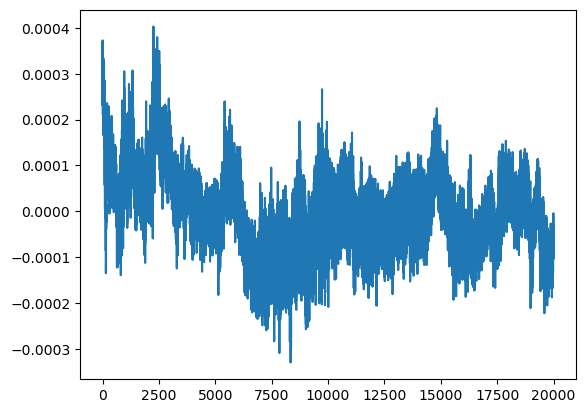

In [ ]:
# Hint based trading #
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt

import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

df = pd.concat([pd.read_csv("../r3/hist_data/0.csv", sep=";"), pd.read_csv("../r3/hist_data/1.csv", sep=";")], ignore_index=True)
# df = pd.read_csv("../r3/hist_data/0.csv", sep=";")

u_df = df[df["product"] == "VOLCANIC_ROCK"].fillna(0)["mid_price"]
k95_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9500"].fillna(0)["mid_price"]
k97_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_9750"].fillna(0)["mid_price"]
k100_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10000"].fillna(0)["mid_price"]
k102_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10250"].fillna(0)["mid_price"]
k105_df = df[df["product"] == "VOLCANIC_ROCK_VOUCHER_10500"].fillna(0)["mid_price"]


def half_d1(S, K, T_days):
    T = T_days / 10000
    return (np.log(K / S)) / np.sqrt(T)

# Implied volatility solver (daily volatility)
def black_scholes_implied(S, K, T, sigma):
    """Black-Scholes price for a European call option"""
    try:
        d1 = (np.log(S / K) + (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    except OverflowError:
        print(S, K, T, sigma)
        return np.nan
    d2 = d1 - sigma * np.sqrt(T)
    # print("d1, d2", d1, d2, S, K, T, sigma)
    return (S * norm.cdf(d1)) - (K * norm.cdf(d2))

def vega(S, K, T, sigma):
    """Derivative of BS price with respect to volatility (vega)"""
    d1 = (np.log(S / K) + (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    # if vega < 0.01:
    #     print(vega, S, K, sigma, T)
    return vega

# Implied volatility solver (daily volatility)
def implied_vol_newton(price, S, K, timestamp, sigma0=0.2, tol=1e-6, max_iter=100, debug=False):
    T = timestamp
    sigma = sigma0
    try:
        for i in range(max_iter):
            implied = black_scholes_implied(S, K, T, sigma)
            diff = implied - price
            if abs(diff) < tol:
                return sigma
            v = vega(S, K, T, sigma)
            if debug:
                # print(implied, price)
                # print(S, K, T, sigma)
                print(diff, v)
            if v < 1e-6:
                # print(v, " breaking")
                break
            change = diff / v
            if sigma - change < 0:
                return sigma
            else:
                sigma -= change
        return sigma
    except OverflowError:
        return 1e-6

def implied_vol_solver(S, K, price, V_t):
    ctr = 0
    for x in range(len(S)):
        bruh = False
        if ctr in [2213,  2223,  2295 , 2319 , 2363,  2416 , 6447, 16111]:
            # print("debug true")
            bruh = True
        T = (70000-x)/10000

        V_t.append(implied_vol_newton(price[x], S[x], K, T, 0.1))

        if x%5000==0:
            print(x)
        ctr += 1

    return half_d1(np.array(S), K, np.array([70000-x for x in range(20000)]))

# V_t = list()

# m_t = list(implied_vol_solver(np.array(u_df), 10250, np.array(k102_df), V_t))
# m_t = m_t + list(implied_vol_solver(np.array(u_df), 9750, np.array(k97_df), V_t))
# m_t = m_t + list(implied_vol_solver(np.array(u_df), 10000, np.array(k100_df), V_t))
# m_t = m_t + list(implied_vol_solver(np.array(u_df), 10250, np.array(k102_df), V_t))
# m_t = m_t + list(implied_vol_solver(np.array(u_df), 10500, np.array(k105_df), V_t))

reg = np.polyfit(np.array(m_t), np.array(V_t), 2)
a,b,c = reg

print(a,b,c)

y_pred = a*(np.array(m_t) ** 2) + b*(np.array(m_t)) + c
res = np.array(V_t) - y_pred

print(np.std(res))

x = np.array([x for x in range(20000)]*1)

# plt.scatter(x[80000:], np.array(V_t)[80000:], s=5, color="b", zorder=0)
# plt.scatter(x[80000:], y_pred[80000:], s=5, color="r", zorder=1)
plt.plot(x, res)

# print(np.array(V_t).shape, np.array(m_t).shape)
# print(np.nonzero(np.array(m_t))[0])


